In [429]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
gen = np.random.default_rng()

In [430]:
A = [1, 2, 3]
B = [3, 2, 1]
categories = ["chores", "finances", "activities"]


In [431]:
def insist(x, priorities):
    return [0, 0, 0]


def compromise(x, priorities):
    return [1, 1, 1]


def random(x, priorities):
    return gen.integers(2, size=3)


def titfortat(x, priorities):
    if x[1] == []:
        return [1, 1, 1]
    return x[1][-1]


def grim(x, priorities):
    if x[1] == []:
        return [1, 1, 1]
    return np.minimum(x[1][-1], x[0][-1])


def gradual_forgiving(x, priorities, n=5):
    if x[1] == []:
        return [1, 1, 1]

    return np.min(x[1][-n:], axis=0)


def prioritised(x, priorities):
    mid = np.argwhere(priorities[0] == 2)[0, 0]
    return np.array([1, titfortat(x, priorities)[mid], 0])[priorities[0]-1]


def considerate(x, priorities):
    ret = [0,0,0]
    for i in range(3):
        if priorities[0][i] > priorities[1][i]:
            ret[i] = 0
        elif priorities[0][i] == priorities[1][i]:
            ret[i] = titfortat(x, priorities)[i]
        else:
            ret[i] = 1
    return ret

strategies = [insist, compromise, titfortat,
              grim, gradual_forgiving, random, prioritised, considerate]

In [432]:
def game(strategy_A, strategy_B, N, priorities=[A, B]):
    priorities = np.array(priorities)
    choices = [[], []]
    for _ in range(N):
        a = strategy_A(choices, priorities)
        b = strategy_B(choices[::-1], priorities[::-1])
        choices[0].append(a)
        choices[1].append(b)
    return np.transpose(np.array(choices))

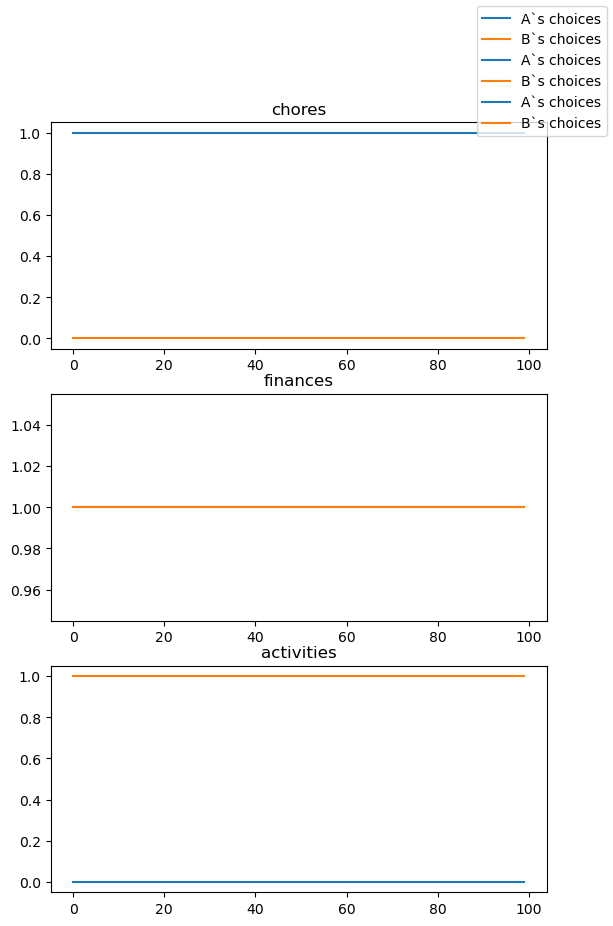

In [433]:
choices = game(considerate, considerate, N=100)
fig, ax = plt.subplots(3)
fig.set_figheight(10)

for i in range(3):
    ax[i].plot(choices[i], label=[f'A`s choices', f'B`s choices'])
    ax[i].set_title(categories[i])
fig.legend()
plt.show()

In [434]:
def mean_payoffs(strategy_A, strategy_B, N=10000, priorities=[A, B]):
    A = priorities[0]
    B = priorities[1]
    subgame_payoffs = np.array([[
        [[0, 0],        [A[i], -B[i]]],
        [[-A[i], B[i]], [1.5, 1.5]]]
        for i in range(3)])

    choices = game(strategy_A, strategy_B, N, priorities)
    ret = np.zeros(2)
    for i in range(3):  # subgame
        for j in range(len(choices[0])):  # iteration
            ret += subgame_payoffs[i, choices[i, j, 0], choices[i, j, 1]]

    return np.round(ret/N, 2)

In [435]:
N = 10000

payoffs = []
for i in range(len(strategies)):
    payoffs.append([])
    for j in range(len(strategies)):
        payoffs[-1].append(mean_payoffs(strategies[i], strategies[j], N = N))

In [436]:
labels = [x.__name__ for x in strategies]
df = pd.DataFrame(payoffs, index=labels, columns=labels)
df
# print(df.to_latex())

,insist,compromise,titfortat,grim,gradual_forgiving,random,prioritised,considerate
insist,"[0.0, 0.0]","[6.0, -6.0]","[0.0, -0.0]","[0.0, -0.0]","[0.0, -0.0]","[2.98, -2.99]","[3.0, -1.0]","[3.0, -1.0]"
compromise,"[-6.0, 6.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[-0.79, 5.26]","[2.0, 6.0]","[2.0, 6.0]"
titfortat,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[1.1, 1.1]","[3.0, 3.0]","[3.0, 3.0]"
grim,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.97, -2.98]","[3.0, 3.0]","[3.0, 3.0]"
gradual_forgiving,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.89, -2.76]","[3.0, 3.0]","[3.0, 3.0]"
random,"[-3.02, 3.01]","[5.26, -0.78]","[1.12, 1.12]","[-2.98, 2.99]","[-2.77, 2.9]","[1.13, 1.12]","[2.11, 2.15]","[2.13, 2.15]"
prioritised,"[-1.0, 3.0]","[6.0, 2.0]","[3.0, 3.0]","[3.0, 3.0]","[3.0, 3.0]","[2.1, 2.12]","[3.5, 3.5]","[3.5, 3.5]"
considerate,"[-1.0, 3.0]","[6.0, 2.0]","[3.0, 3.0]","[3.0, 3.0]","[3.0, 3.0]","[2.12, 2.13]","[3.5, 3.5]","[3.5, 3.5]"


In [437]:
def stochastic(x, p, priorities):
    if x[1] == [] or x[0] == []:
        return [1,1,1]
    p = np.array(p)
    prob = [p[i][2 * np.array(x[0][-1]) + np.array(x[1][-1])][i] for i in range(3)]

    return [gen.choice(a=2, p = [1 - prob[i], prob[i]]) for i in range(3)]

# p = [[0,1,0,1],
#      [1,0,1,0],
#      [0,0,0,1]]

# x = [[[1,1,1],[1,0,1]],[[1,1,1],[0,1,1]]]

# stochastic(x, p, priorities = [A,B])

In [438]:
p = [[0,1,0,1],
     [1,0,1,0],
     [0,0,0,0]]
  # p_dd, p_dc, p_cd, p_cc
def stoch(x, priorities): return stochastic(x, p, priorities)


game(stoch, grim, N=1000)

array([[[1, 1],
        [1, 1],
        [1, 1],
        ...,
        [1, 1],
        [1, 1],
        [1, 1]],

       [[1, 1],
        [0, 1],
        [0, 0],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]],

       [[1, 1],
        [0, 1],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]]])

In [439]:
def p_evolution(M, N, Q, replaced, rate, priorities=[A, B]):
    scores = np.zeros([Q, M])
    p = gen.uniform(size=[M, 3, 4])
    replaced = int(M * replaced)

    for k in range(Q):
        for i in range(M):
            def s1(x, y): return stochastic(x, p[i], y)
            for s2 in strategies:
                payoffA = mean_payoffs(s1, s2, N=N)
                # payoffB = mean_payoffs(s2, s1, N=N)
                scores[k, i] += payoffA[0]
                # scores[k, i] += payoffB[1]

            for j in range(1, replaced+1):
                if k == 0:
                    break

                def s2(x, y): return stochastic(x, p[inds[-j]], y)

                payoffA = mean_payoffs(s1, s2, N=N, priorities=priorities)
                # payoffB = mean_payoffs(s2, s1, N=N, priorities=priorities)
                scores[k, i] += payoffA[0]
                # scores[k, i] += payoffB[1]

        inds = np.argsort(scores[k])
        p[inds[:replaced]] = np.clip(
            p[inds[-replaced:]] + gen.normal(scale=rate, size=[replaced, 3, 4]), 0, 1)
    scores /= (replaced + len(strategies))

    inds = np.argsort(scores[-1])
    scores = scores[:, inds]
    p = p[inds]
    return p, scores

In [440]:
M = 1000  # number of strategies
N = 100  # number of rounds each game
Q = 50  # number of iterations
replaced = 0.1  # proportion of strategies replaced each generation
evolution_rate = 0.1  # rate of mutation

p, scores = p_evolution(M, N, Q, replaced, evolution_rate)

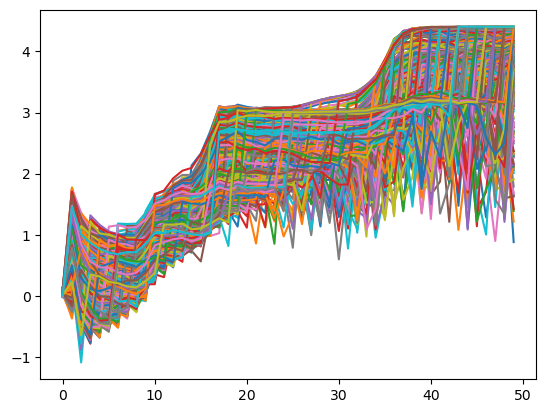

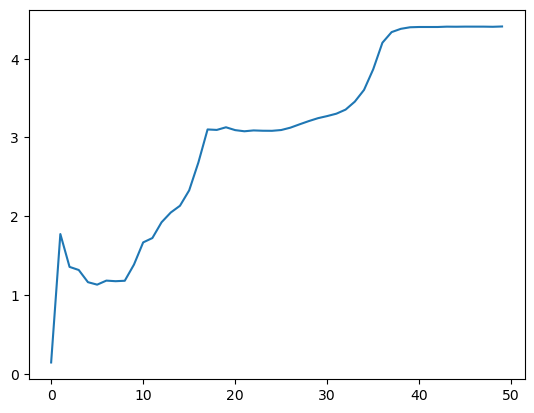

In [441]:
bestscores = scores[:,-int(M * replaced):]
plt.plot(scores)
plt.show()
plt.plot(np.max(scores,axis=1))
plt.show()


In [442]:
print(scores[-1])
print(p)

[0.8787963  1.21287037 1.38916667 1.41833333 1.61944444 1.63861111
 1.67759259 1.78796296 1.90731481 2.01064815 2.0612037  2.09037037
 2.11175926 2.1325     2.14148148 2.15833333 2.25768519 2.27509259
 2.28981481 2.29185185 2.29546296 2.31185185 2.36694444 2.36703704
 2.49194444 2.52787037 2.54583333 2.59666667 2.6412963  2.65296296
 2.67268519 2.67574074 2.69527778 2.75898148 2.79712963 2.83425926
 2.84648148 2.89972222 2.92962963 3.01740741 3.05444444 3.09240741
 3.10083333 3.11074074 3.11157407 3.11787037 3.13962963 3.14277778
 3.15074074 3.17018519 3.17231481 3.17296296 3.17351852 3.17444444
 3.17490741 3.17509259 3.17509259 3.17638889 3.17648148 3.1775
 3.17814815 3.17842593 3.18092593 3.18175926 3.18185185 3.18287037
 3.18351852 3.18361111 3.18472222 3.18527778 3.18611111 3.1862963
 3.18648148 3.18685185 3.18805556 3.18814815 3.18824074 3.18851852
 3.18907407 3.18972222 3.19009259 3.19018519 3.19018519 3.19092593
 3.19111111 3.1912037  3.19138889 3.19212963 3.19240741 3.19351852
